# Phase 5: Calibration of Some Models for $t=2$

## Setup

In [105]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
import random
seed_val = 43
np.random.seed(seed_val)
random.seed(seed_val)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Data Loading

In [106]:
seed = 42
train_set = pd.read_csv(f"datasets/train_set_{seed}_t_2.csv")

In [107]:
X = train_set.drop(['is_drop'], axis=1)
y = train_set['is_drop'].copy()
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25406 entries, 0 to 25405
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index_o            25406 non-null  int64  
 1   year               25406 non-null  int64  
 2   semester           25406 non-null  int64  
 3   grade              25406 non-null  int64  
 4   sex                25406 non-null  object 
 5   gpa_last_seme      25406 non-null  float64
 6   credits_last_seme  25406 non-null  float64
 7   credits_tot        25406 non-null  float64
 8   n_seme             25406 non-null  int64  
 9   years_since        25406 non-null  int64  
 10  college            25406 non-null  object 
 11  adm_unit           25406 non-null  int64  
 12  nation             25406 non-null  int64  
 13  in_capa            25406 non-null  bool   
 14  leave              25406 non-null  bool   
dtypes: bool(2), float64(3), int64(8), object(2)
memory usage: 2.6+ MB


## Data Transformation

In [108]:
# Label encoding for categorical features
def sex_mapping(sex):
    sex_map = {'M': 0, 'F': 1}
    return sex_map[sex]

def seme_mapping(seme):
    seme_map = {1: 0, 2: 1}
    return seme_map[seme]

def college_mapping(college):
    college_map = {'TH': 0, 'HS': 1, 'BZ': 2, 'HT': 3, 'EG': 4, 'SW': 5, 'AT': 6}
    return college_map[college]


In [109]:
# Label encoding for categrical features
def label_encoding(data):
    data['sex'] = data['sex'].map(sex_mapping)
    data['semester'] = data['semester'].map(seme_mapping)
    data['college'] = data['college'].map(college_mapping)

In [110]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


num_attrs = [ 'grade', 'gpa_last_seme', 'credits_last_seme', 'credits_tot', 'n_seme', 'years_since']
cat_attrs = ['semester', 'sex', 'adm_unit', 'nation', 'in_capa', 'college', 'leave']

full_pipeline = ColumnTransformer([
    ('num', StandardScaler(), num_attrs),
    ('cat', OneHotEncoder(), cat_attrs)
])

cat_pipeline = ColumnTransformer([
    ('num', StandardScaler(), num_attrs),
    ('cat', 'passthrough', cat_attrs)
])

X_1hot = full_pipeline.fit_transform(X)
label_encoding(X)
X_t = cat_pipeline.fit_transform(X)
X_cat = cat_pipeline.fit_transform(X) # for CatBoost
X_1hot = pd.DataFrame(X_1hot, columns=full_pipeline.get_feature_names_out())
X = pd.DataFrame(X_t, columns=cat_pipeline.get_feature_names_out())
X_cat = pd.DataFrame(X_cat, columns=cat_pipeline.get_feature_names_out())

cat_indices = [6, 7, 8, 9, 10, 11, 12]

# Typesetting 
num_cols = ['num__grade', 'num__gpa_last_seme', 'num__credits_last_seme', 'num__credits_tot', 'num__n_seme', 'num__years_since']
cat_cols = list(set(X.columns) - set(num_cols))

X[num_cols] = X[num_cols].astype(float)
X[cat_cols] = X[cat_cols].astype(int)


## Model Test on Brier Scores

In [111]:
test_set = pd.read_csv(f"datasets/test_set_{seed}_t_2.csv")

X_te = test_set.drop(['is_drop'], axis=1)
X_te_1hot = full_pipeline.transform(test_set)
label_encoding(test_set)
X_te_full = cat_pipeline.transform(test_set)
X_te_full_cat = cat_pipeline.transform(test_set)
y_te_full = test_set['is_drop'].copy()

X_te_1hot = pd.DataFrame(X_te_1hot, columns=full_pipeline.get_feature_names_out())
X_te_full = pd.DataFrame(X_te_full, columns=cat_pipeline.get_feature_names_out())
X_te_full_cat = pd.DataFrame(X_te_full_cat, columns=cat_pipeline.get_feature_names_out())

# for LightGBM and XGBoost
X_te_full[num_cols] = X_te_full[num_cols].astype(float)
X_te_full[cat_cols] = X_te_full[cat_cols].astype(int)

In [112]:
X_te_full_cat.rename(columns={'num__grade': 'year', 'num__gpa_last_seme': 'gpa_last', 'num__credits_last_seme': 'credits_last',
                  'num__credits_tot': 'credits_tot', 'num__n_seme': 'n_semesters', 'num__years_since': 'years_since',
                  'cat__semester': 'release', 'cat__sex': 'sex', 'cat__adm_unit': 'adm_type', 'cat__nation': 'nation',
                  'cat__in_capa': 'in_capa', 'cat__college': 'college', 'cat__leave': 'status'}, inplace=True)

In [113]:
from sklearn.metrics import (
    precision_recall_curve, roc_curve, roc_auc_score, average_precision_score,
    recall_score, precision_score, f1_score, matthews_corrcoef
)

from pprint import pprint

# function to train models and evaluate the performance
def test_model(clf, X_test, y_test, thre): 
    if (type(clf).__name__ == 'SVC'):
        y_score = clf.decision_function(X_test)
    else: y_score = clf.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_score)
    ap = average_precision_score(y_test, y_score)

    if (type(clf).__name__ == 'SVC'):
        y_pred = (y_score >= 0)
    else: y_pred = (y_score >= 0.5)
    recall_no = recall_score(y_test, y_pred)
    preci_no = precision_score(y_test, y_pred)
    f1_no = f1_score(y_test, y_pred)

    # Maximizing F1-score
    y_pred = (y_score >= thre)
    recall_opt = recall_score(y_test, y_pred)
    preci_opt = precision_score(y_test, y_pred)
    f1_opt = f1_score(y_test, y_pred)

    res = {'auc': auc, 'ap': ap, 'recall': recall_no, 'precision': preci_no, 'f1': f1_no, 
           'recall(opt)': recall_opt, 'precision(opt)': preci_opt, 'f1(opt)': f1_opt,
           'threshold': thre}
    print("model: ", type(clf).__name__)
    pprint(res)
    print()
    return res

In [114]:
# function to measure whether a model is calibrated or not

from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve

def measure_calibration(clf, X_test, y_test, n_bins=5):
    prob_uncal = clf.predict_proba(X_test)[:, 1]
    brier_uncal = brier_score_loss(y_test, prob_uncal)

    print(f'Brier score: {round(brier_uncal, 4)}')
    frac_positive, mean_prob = calibration_curve(y_test, prob_uncal, n_bins=n_bins)
    return {'real_proba': frac_positive, 'pred_proba': mean_prob}

Load the trained models

In [115]:
import joblib

loaded_model = joblib.load(f'models/base_mlp_1_2.pkl')
mlp_clf = loaded_model['model']

loaded_model = joblib.load(f'models/base_xgb_1_2.pkl')
xgb_clf = loaded_model['model']

loaded_model = joblib.load(f'models/base_cat_1_2.pkl')
cat_clf = loaded_model['model']

loaded_model = joblib.load(f'models/stack_1_2.pkl')
stk_clf = loaded_model['model']

loaded_model = joblib.load(f'models/imbal_default_cat_1_2.pkl')
cat_smote = loaded_model['model']['smote']
cat_cnn = loaded_model['model']['cnn']
cat_tomek = loaded_model['model']['tomek']
cat_enn = loaded_model['model']['enn']


In [116]:
cal_mlp = measure_calibration(mlp_clf, X_te_1hot, y_te_full, 5)
cal_xgb = measure_calibration(xgb_clf, X_te_full, y_te_full, 5)
cal_cat = measure_calibration(cat_clf, X_te_full_cat, y_te_full, 5)
cal_stk = measure_calibration(stk_clf, X_te, y_te_full, 5)

Brier score: 0.036
Brier score: 0.0344
Brier score: 0.0337
Brier score: 0.0351


In [117]:
cal_smote = measure_calibration(cat_smote, X_te_full, y_te_full, 5)
cal_cnn = measure_calibration(cat_cnn, X_te_full, y_te_full, 5)
cal_tomek = measure_calibration(cat_tomek, X_te_full, y_te_full, 5)
cal_enn = measure_calibration(cat_enn, X_te_full, y_te_full, 5)

Brier score: 0.0395
Brier score: 0.0534
Brier score: 0.0335
Brier score: 0.0381


In [118]:

def plot_calibration_curve(data, label): 
    plt.figure(figsize=(6, 4))
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    plt.plot(data['pred_proba'], data['real_proba'], marker='o',\
            markersize=5, label=label)
    plt.xlabel('Predicted Probabilities', fontsize=12)
    plt.ylabel('True Probabilities', fontsize=12)
    #plt.title('Calibration Curve (Test Set)')


Final Plot **without** Re-calibration

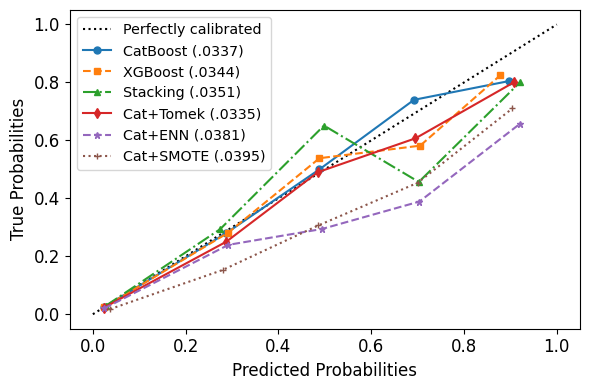

In [131]:
plot_calibration_curve(cal_cat, 'CatBoost (.0337)')
plt.plot(cal_xgb['pred_proba'], cal_xgb['real_proba'], '--',
         marker='s', markersize=5, label='XGBoost (.0344)')
plt.plot(cal_stk['pred_proba'], cal_stk['real_proba'], '-.',
         marker='^', markersize=5, label='Stacking (.0351)')
plt.plot(cal_tomek['pred_proba'], cal_tomek['real_proba'], '-',
         marker='d', markersize=5, label='Cat+Tomek (.0335)')
plt.plot(cal_enn['pred_proba'], cal_enn['real_proba'], '--', 
         marker='*', markersize=5, label='Cat+ENN (.0381)')
plt.plot(cal_smote['pred_proba'], cal_smote['real_proba'], ':', 
         marker='+', markersize=5, label='Cat+SMOTE (.0395)')
plt.legend(fontsize=10.3)

plt.tight_layout()
plt.savefig('figs/cal_curve_1.jpg', dpi=1200)

## Re-calibration

Separating validation set from test set

In [120]:
test_set = pd.read_csv(f"datasets/test_set_{seed}_t_2.csv")

In [121]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for valid_index, test_index in split.split(test_set, test_set['is_drop']):
    valid_set = test_set.loc[valid_index]
    test_set = test_set.loc[test_index]

valid_set.reset_index(inplace=True, drop=True)
test_set.reset_index(inplace=True, drop=True)

In [122]:
X_va = valid_set.drop(['is_drop'], axis=1)
y_va = valid_set['is_drop'].copy()

X_va_1hot = full_pipeline.transform(valid_set)

label_encoding(valid_set)
X_va_full = cat_pipeline.transform(valid_set)
X_va_cat = cat_pipeline.transform(valid_set)

X_va_1hot = pd.DataFrame(X_va_1hot, columns=full_pipeline.get_feature_names_out())
X_va_full = pd.DataFrame(X_va_full, columns=cat_pipeline.get_feature_names_out())
X_va_cat = pd.DataFrame(X_va_cat, columns=cat_pipeline.get_feature_names_out())

X_va_full[num_cols] = X_va_full[num_cols].astype(float)
X_va_full[cat_cols] = X_va_full[cat_cols].astype(int)

In [123]:
X_te = test_set.drop(['is_drop'], axis=1)
y_te = test_set['is_drop'].copy()

X_te_1hot = full_pipeline.transform(test_set)

label_encoding(test_set)
X_te_full = cat_pipeline.transform(test_set)
X_te_cat = cat_pipeline.transform(test_set)

X_te_1hot = pd.DataFrame(X_te_1hot, columns=full_pipeline.get_feature_names_out())
X_te_full = pd.DataFrame(X_te_full, columns=cat_pipeline.get_feature_names_out())
X_te_cat = pd.DataFrame(X_te_cat, columns=cat_pipeline.get_feature_names_out())

X_te_full[num_cols] = X_te_full[num_cols].astype(float)
X_te_full[cat_cols] = X_te_full[cat_cols].astype(int)

In [124]:
X_va_cat.rename(columns={'num__grade': 'year', 'num__gpa_last_seme': 'gpa_last', 'num__credits_last_seme': 'credits_last',
                  'num__credits_tot': 'credits_tot', 'num__n_seme': 'n_semesters', 'num__years_since': 'years_since',
                  'cat__semester': 'release', 'cat__sex': 'sex', 'cat__adm_unit': 'adm_type', 'cat__nation': 'nation',
                  'cat__in_capa': 'in_capa', 'cat__college': 'college', 'cat__leave': 'status'}, inplace=True)

X_te_cat.rename(columns={'num__grade': 'year', 'num__gpa_last_seme': 'gpa_last', 'num__credits_last_seme': 'credits_last',
                  'num__credits_tot': 'credits_tot', 'num__n_seme': 'n_semesters', 'num__years_since': 'years_since',
                  'cat__semester': 'release', 'cat__sex': 'sex', 'cat__adm_unit': 'adm_type', 'cat__nation': 'nation',
                  'cat__in_capa': 'in_capa', 'cat__college': 'college', 'cat__leave': 'status'}, inplace=True)

In [125]:
from sklearn.calibration import CalibratedClassifierCV

def calibrate_model(model, X_val, y_val, X_test, y_test, 
                          method='sigmoid', n_bins=5):
    # Calibrate the model on the validation data using Platt's scaling
    scaling = CalibratedClassifierCV(model, \
        method=method, cv='prefit')
    scaling.fit(X_val, y_val)
    # Get model probabilities on test set (calibrated model)
    probs_ps = scaling.predict_proba(X_test)[:, 1]
    # Compute Brier score for Platt's scaling calibrated model
    brier_platt = brier_score_loss(y_test, probs_ps)
    print(f"Brier Score for Platt's Scaled Model: \
        {round(brier_platt, 4)}")
    # Compute the calibration curve for Platt's scaling
    frac_positive, mean_prob = calibration_curve(y_test, probs_ps, n_bins=n_bins)

    return {'real_proba': frac_positive, 'pred_proba': mean_prob}


### Baseline models

In [126]:
platt_cat = calibrate_model(cat_clf, X_va_cat, y_va,
                X_te_cat, y_te, method='sigmoid', n_bins=5)
platt_xgb = calibrate_model(xgb_clf, X_va_full, y_va, 
                X_te_full, y_te, method='sigmoid', n_bins=5)
platt_stk = calibrate_model(stk_clf, X_va, y_va,
                X_te, y_te, method='sigmoid', n_bins=5)
platt_mlp = calibrate_model(mlp_clf, X_va_1hot, y_va,
                X_te_1hot, y_te, method='sigmoid', n_bins=5)

Brier Score for Platt's Scaled Model:         0.0332
Brier Score for Platt's Scaled Model:         0.0345
Brier Score for Platt's Scaled Model:         0.0334
Brier Score for Platt's Scaled Model:         0.036


### Models trained on resampled dataset

In [127]:
platt_tomek = calibrate_model(cat_tomek, X_va_full, y_va, 
                X_te_full, y_te, method='sigmoid', n_bins=5)
platt_enn = calibrate_model(cat_enn, X_va_full, y_va, 
                X_te_full, y_te, method='sigmoid', n_bins=5)
platt_cnn = calibrate_model(cat_cnn, X_va_full, y_va,
                X_te_full, y_te, method='sigmoid', n_bins=5)
platt_smote = calibrate_model(cat_smote, X_va_full, y_va,
                X_te_full, y_te, method='sigmoid', n_bins=5)

Brier Score for Platt's Scaled Model:         0.0335
Brier Score for Platt's Scaled Model:         0.0342
Brier Score for Platt's Scaled Model:         0.0336
Brier Score for Platt's Scaled Model:         0.0343


### Final Plot after Re-calibration

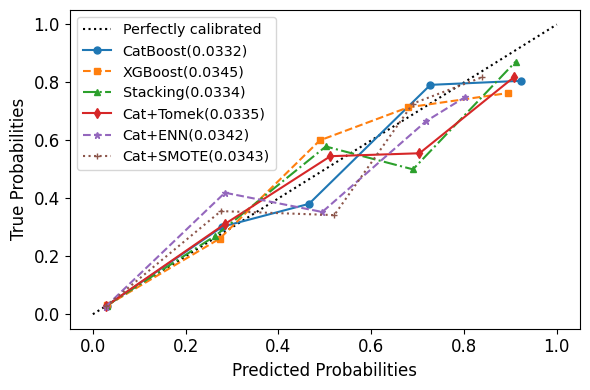

In [128]:
plot_calibration_curve(platt_cat, 'CatBoost(0.0332)')
plt.plot(platt_xgb['pred_proba'], platt_xgb['real_proba'], '--',
        marker='s', markersize=5, label='XGBoost(0.0345)')
plt.plot(platt_stk['pred_proba'], platt_stk['real_proba'], '-.',\
        marker='^', markersize=5, label='Stacking(0.0334)')
plt.plot(platt_tomek['pred_proba'], platt_tomek['real_proba'], '-',
          marker='d', markersize=5, label='Cat+Tomek(0.0335)')
plt.plot(platt_enn['pred_proba'], platt_enn['real_proba'], '--', 
         marker='*', markersize=5, label='Cat+ENN(0.0342)')
plt.plot(platt_smote['pred_proba'], platt_smote['real_proba'], ':',
         marker='+', markersize=5, label='Cat+SMOTE(0.0343)')
plt.legend(fontsize=10.3)

plt.tight_layout()
plt.savefig('figs/cal_curve_2.jpg', dpi=1200)
#plt.show()

In [129]:
iso_cat = calibrate_model(cat_clf, X_va_cat, y_va, 
                X_te_cat, y_te, method='isotonic', n_bins=5)
iso_xgb = calibrate_model(xgb_clf, X_va_full, y_va, 
                X_te_full, y_te, method='isotonic', n_bins=5)
iso_stk = calibrate_model(stk_clf, X_va, y_va,
                X_te, y_te, method='isotonic', n_bins=5)
iso_tomek = calibrate_model(cat_tomek, X_va_full, y_va, 
                X_te_full, y_te, method='isotonic', n_bins=5)
iso_enn = calibrate_model(cat_enn, X_va_full, y_va, 
                X_te_full, y_te, method='isotonic', n_bins=5)
iso_smote = calibrate_model(cat_smote, X_va_full, y_va,
                X_te_full, y_te, method='isotonic', n_bins=5)

Brier Score for Platt's Scaled Model:         0.0327
Brier Score for Platt's Scaled Model:         0.0335
Brier Score for Platt's Scaled Model:         0.0324
Brier Score for Platt's Scaled Model:         0.0327
Brier Score for Platt's Scaled Model:         0.0333
Brier Score for Platt's Scaled Model:         0.0343


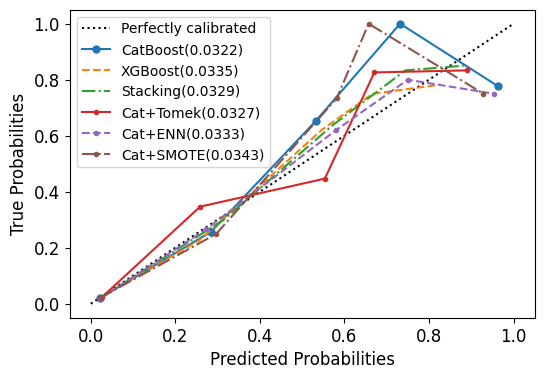

In [130]:
plot_calibration_curve(iso_cat, 'CatBoost(0.0322)')
plt.plot(iso_xgb['pred_proba'], iso_xgb['real_proba'], '--',\
            label='XGBoost(0.0335)')
plt.plot(iso_stk['pred_proba'], iso_stk['real_proba'], '-.',\
            label='Stacking(0.0329)')
plt.plot(iso_tomek['pred_proba'], iso_tomek['real_proba'], '-', marker='.',\
            label='Cat+Tomek(0.0327)')
plt.plot(iso_enn['pred_proba'], iso_enn['real_proba'], '--', marker='.',\
            label='Cat+ENN(0.0333)')
plt.plot(iso_smote['pred_proba'], iso_smote['real_proba'], '-.', marker='.',\
            label='Cat+SMOTE(0.0343)')
plt.legend(fontsize=10)
plt.show()